# titiler-pgstac

As a part of the [OpenAerialMap modernization effort](https://www.hotosm.org/updates/openaerialmap-v2/), we've deployed an instance of [titiler-pgstac](https://github.com/stac-utils/titiler-pgstac).
This [titler](https://github.com/developmentseed/titiler) allows us to create dynamic mosaics using STAC API search queries.
In this notebook, we'll demonstrate how to create and use a dynamic mosaic for a single collection in the [Maxar open data catalog](https://registry.opendata.aws/maxar-open-data/).

For more detail and examples on using **titiler-pgstac** and **eoAPI**, see their [getting started guide](https://github.com/developmentseed/eoAPI/blob/main/docs/src/notebooks/getting-started.ipynb).
For the dependencies used in this notebook, see [this repo's](https://github.com/hotosm/OpenAerialMap) `pyproject.toml`.

## Inspection

Before creating the mosaic, let's use [pystac-client](https://github.com/stac-utils/pystac-client) and other tools to find and visualize the extents of the data we're going to use.
The [HOT OAM STAC catalog](https://hot-oam.ds.io/stac) includes a [Maxar Open Data Collection](https://hot-oam.ds.io/stac/collections/maxar-opendata)

In [ ]:
import urllib.parse
from pystac_client import Client

HOT_OAM_ROOT_URL = "https://api.oam.hotosm.org"
HOT_OAM_STAC_URL = urllib.parse.urljoin(HOT_OAM_ROOT_URL, "stac")
client = Client.open(HOT_OAM_STAC_URL)
print("Collections:")
maxar_collections = []
for collection in client.get_collections():
    print("-", collection.id)
    if "maxar" in collection.id.lower():
        maxar_collections.append(collection.id)

print("\nMaxar collections:", ", ".join(maxar_collections))

Collections:
- maxar-opendata
- noaa-emergency-response
- openaerialmap

Maxar collections: maxar-opendata


Each Maxar item includes a `catalog_id` attribute, which can be used to filter items.
In this example, we'll look for all Maxar items that are over Colorado, USA, and figure out which `catalog_id` we want to use from there.

In [2]:
import json

COLORADO_BBOX = [-109.0591, 36.9928, -102.0421, 41.0020]
catalog_ids = {}
item_search = client.search(collections=["maxar-opendata"], bbox=COLORADO_BBOX)
for item in item_search.items():
    if item.properties["catalog_id"] not in catalog_ids:
        catalog_ids[item.properties["catalog_id"]] = item.properties["title"]

print(json.dumps(catalog_ids, indent=2))

{
  "10200100BCB1A500": "Marshall Fire - MXRA-Z13-031131113310"
}


Hey look, there's only one!

Now that we know the catalog id `10200100BCB1A500`, we can create a dynamic mosaic for that catalog id.
Before we do that, though, let's see what items we have for that `catalog_id`.
To do so, we'll use [cql2](https://www.ogc.org/standards/cql2/), an [OGC](https://www.ogc.org/) standard for querying spatial data.
CQL2 can be a bit klunky to write, especially in its more verbose **cql2-json** form, so we'll use the [cql2](https://github.com/developmentseed/cql2-rs/) helper library to turn easy-to-read text into **cql2-json**.

In [3]:
import cql2

cql2_text = "catalog_id='10200100BCB1A500'"
cql2_json = cql2.parse_text(cql2_text).to_json()
print(json.dumps(cql2_json, indent=2))

item_search = client.search(collections=["maxar-opendata"], filter=cql2_json)
item_collection = item_search.item_collection()

{
  "op": "=",
  "args": [
    {
      "property": "catalog_id"
    },
    "10200100BCB1A500"
  ]
}


We've got fifteen items, let's visualize their geometries on a simple map.

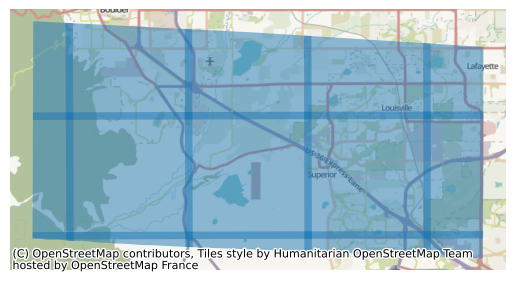

In [4]:
import contextily
from geopandas import GeoDataFrame

data_frame = GeoDataFrame.from_features(
    item_collection.to_dict(), crs="EPSG:4326"
)  # STAC items are always WGS84 because they're GeoJSON
axes = data_frame.to_crs(epsg=3857).plot(alpha=0.5)
contextily.add_basemap(axes)
axes.set_axis_off()

Now, let's create our dynamic mosaic.

## Dynamic mosaic

We'll use a new endpoint from **titiler-pgstac** (API documentation: <https://api.imagery.hotosm.org/raster/api.html>).
There isn't bespoke client, so we'll just use a generic one from **httpx**.
We'll POST to register a new search.

In [5]:
from httpx import Client

HOT_OAM_RASTER_URL = urllib.parse.urljoin(HOT_OAM_ROOT_URL, "raster/")

search = {
    "collections": ["maxar-opendata"],
    "filter": cql2_json,
}

client = Client()
response = client.post(urllib.parse.urljoin(HOT_OAM_RASTER_URL, "searches/register"), json=search)
response.raise_for_status()
data = response.json()
print(json.dumps(data, indent=2))

{
  "id": "25cbe8b7ebe2fc01198c9573e0ef3566",
  "links": [
    {
      "href": "https://hot-oam.ds.io/raster/searches/25cbe8b7ebe2fc01198c9573e0ef3566/info",
      "rel": "metadata",
      "title": "Mosaic metadata"
    },
    {
      "href": "https://hot-oam.ds.io/raster/searches/25cbe8b7ebe2fc01198c9573e0ef3566/{tileMatrixSetId}/tilejson.json",
      "rel": "tilejson",
      "templated": true,
      "title": "Link for TileJSON (Template URL)"
    },
    {
      "href": "https://hot-oam.ds.io/raster/searches/25cbe8b7ebe2fc01198c9573e0ef3566/{tileMatrixSetId}/map",
      "rel": "map",
      "templated": true,
      "title": "Link for Map viewer (Template URL)"
    },
    {
      "href": "https://hot-oam.ds.io/raster/searches/25cbe8b7ebe2fc01198c9573e0ef3566/{tileMatrixSetId}/WMTSCapabilities.xml",
      "rel": "wmts",
      "templated": true,
      "title": "Link for WMTS (Template URL)"
    }
  ]
}


We've now registered a search, with an ID, that we can use to create dynamic maps or WMTS endpoints.
You'll just need to do a couple things to that output url:

- Replace `{tileMatrixSetId}` with `WebMercatorQuad`
- Add an `?assets=visual` to the end to tell **titiler** what to render

In [6]:
response = client.get(urllib.parse.urljoin(HOT_OAM_RASTER_URL, f"searches/{data['id']}/tiles/WebMercatorQuad"))
response.raise_for_status()
data = response.json()
link = next(link for link in data["links"] if link["rel"] == "tile")
tiles_href = link["href"] + "?assets=visual"
tiles_href

'https://hot-oam.ds.io/raster/searches/25cbe8b7ebe2fc01198c9573e0ef3566/tiles/WebMercatorQuad/{z}/{x}/{y}?assets=visual'

We can visualize with [folium](https://python-visualization.github.io/folium/latest/getting_started.html).

In [7]:
from folium import Map, TileLayer

map = Map(location=[39.9778, -105.1319], zoom_start=13)
TileLayer(tiles_href, min_zoom=12, attr="©️ Maxar https://www.maxar.com/open-data").add_to(map)
map

## An alternative approach

**titiler-pgstac** also supports dynamic GET queries to generate WMTS endpoints on the fly, based on bounding box and datetime queries.
So in this case, we can use our Colorado bounding box and the date bounds of the Marshall Fire to get the same result, no POST requests required.

In [8]:
url = urllib.parse.urljoin(HOT_OAM_RASTER_URL, "collections/maxar-opendata/WebMercatorQuad/WMTSCapabilities.xml")
response = client.get(url, params={
    "bbox": ",".join(str(b) for b in COLORADO_BBOX),
    "datetime": "2025-04-01T00:00:00Z/2025-05-01T00:00:00Z"
})
response.raise_for_status()
print(response.content.decode()[0:200] + "...")

<Capabilities xmlns="http://www.opengis.net/wmts/1.0" xmlns:ows="http://www.opengis.net/ows/1.1" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:...
